In [27]:
import re
import string
import glob

import os
import sys
import pandas as pd
import numpy as np
# import gensim
import zipfile
import urllib.request
import tensorflow as tf

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import joblib
import pandas as pd

from unidecode import unidecode
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# import spacy
import nltk

sys.path.append(os.path.abspath('..'))
from text_processing_utils import preprocess_text

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense

output_dir = "../data/sentiment140"
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

In [6]:
# Use glob to get a list of CSV files in the directory
csv_files = glob.glob(f'{output_dir}/*.csv')

# Now, csv_files contains a list of paths to all CSV files in the directory
for csv_file in csv_files:
    print(csv_file)

../data/sentiment140/debug16000.csv
../data/sentiment140/debug1600.csv
../data/sentiment140/training.1600000.processed.noemoticon.csv
../data/sentiment140/debug.csv
../data/sentiment140/debug160000.csv


In [7]:
# Read the CSV file into a DataFrame with the specified encoding and column names
df = pd.read_csv(csv_files[0], encoding=DATASET_ENCODING)
# df = pd.read_csv(csv_files[0], encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

# Display the first few rows of the DataFrame to check the data
df.head(3)


,target,ids,date,flag,user,text
0,0,2060659214,Sat Jun 06 19:19:41 PDT 2009,NO_QUERY,Goodbyeadam,I think my car is dying. It's so loud
1,4,1962960561,Fri May 29 11:59:25 PDT 2009,NO_QUERY,MissNun_ya,hoping to figure out how to get updates to go ...
2,0,1999925049,Mon Jun 01 21:04:29 PDT 2009,NO_QUERY,Vanache,@k_rockNsoul - I haven't been able to load the...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  16000 non-null  int64 
 1   ids     16000 non-null  int64 
 2   date    16000 non-null  object
 3   flag    16000 non-null  object
 4   user    16000 non-null  object
 5   text    16000 non-null  object
dtypes: int64(2), object(4)
memory usage: 750.1+ KB


In [9]:
df["target"] = df["target"].replace(4, 1)
df['text'] = df['text'].apply(preprocess_text)
df = df[['text', 'target']]

In [10]:
df.head(10)

,text,target
0,think car dying loud,0
1,hoping figure get update go phone think twitte...,1
2,able load yet laptop busted gon na take,0
3,got pogo stick,1
4,well make mind,0
5,mm yay work hour tomorrow hour tuesday cant la...,0
6,come extra litter cat food anytime,1
7,ohhhhh hope turn perfectly,1
8,ill check wana win ticket show cuz im poor hahha,0
9,sure right would able persuade,0


In [11]:
# Save the preprocessed DataFrame to a CSV file
df.to_csv('../data/preprocessed_df1600.csv', index=False)


In [40]:
# Load the preprocessed DataFrame
df = pd.read_csv('../data/preprocessed_df16000.csv')

In [11]:
# Remove rows with NaN values in the text column
df = df.dropna(how='any', subset=['text'])

# Print the DataFrame
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   target  16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB


In [12]:
tweet_df = df.copy()

In [13]:
from sklearn.model_selection import train_test_split

# Split the data into training (95%) and test (5%) sets
X_train, X_test, y_train, y_test = train_test_split(tweet_df['text'], tweet_df['target'], test_size=0.25, random_state=42)

In [14]:
display(len(X_train))
display(len(X_test))
display(len(y_train))
display(len(y_test))

12000

4000

12000

4000

In [15]:
# Define the URL to download the GloVe word vectors file
glove_url = "https://nlp.stanford.edu/data/glove.6B.zip"

# Define the directory to store the downloaded file and the target file name
download_dir = "../data/glove_download"
zip_file_path = os.path.join(download_dir, "glove.zip")

In [16]:
import os
# Create the download directory if it doesn't exist
if not os.path.exists(download_dir):
    os.makedirs(download_dir)


In [17]:
# Download the GloVe zip file
if not os.path.exists(zip_file_path):
    print(f"Downloading GloVe from {glove_url}")
    urllib.request.urlretrieve(glove_url, zip_file_path)
    print("Download complete!")

KeyboardInterrupt: 

In [18]:
# Unzip the GloVe zip file
glove_dir = os.path.join(download_dir, "glove")
if not os.path.exists(glove_dir):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(glove_dir)
    print(f"GloVe files extracted to {glove_dir}")

GloVe files extracted to ../data/glove_download/glove


In [19]:
# Get the path to the glove.6B.300d.txt file
glove_file_path = os.path.join(glove_dir, "glove.6B.300d.txt")
# Check if the file exists
if os.path.exists(glove_file_path):
    print(f"Path to GloVe file: {glove_file_path}")
else:
    print("GloVe file not found!")

Path to GloVe file: ../data/glove_download/glove/glove.6B.300d.txt


In [20]:
# Load GloVe word embeddings
# glove_50 = "data/glove_download/glove/glove.6B.50d.txt"
embeddings_dict = {}
with open(glove_file_path, 'r', encoding="utf-8") as f:
    for line in f:
        word, *embedding = line.strip().split()
        embeddings_dict[word] = np.array(embedding, dtype=float)


In [21]:
len(embeddings_dict)

400000

In [22]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Create a tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert the text to sequences of indices
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences so all of them have the same length
max_len = 150
X_train_seq = pad_sequences(X_train_seq, maxlen=max_len)
X_test_seq = pad_sequences(X_test_seq, maxlen=max_len)


In [23]:
from keras.layers import Embedding

# Create an embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [24]:
import mlflow

# Check if the experiment exists, and if not, create it
experiment_name = "lstm_model"
if not mlflow.get_experiment_by_name(experiment_name):
    mlflow.create_experiment(experiment_name)

mlflow.set_experiment(experiment_name)

/Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/.venv2/lib/python3.10/site-packages/pydantic/_internal/_fields.py:128: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/.venv2/lib/python3.10/site-packages/pydantic/_internal/_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


<Experiment: artifact_location='file:///Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/notebooks/mlruns/533166044865263743', creation_time=1695934009457, experiment_id='533166044865263743', last_update_time=1695934009457, lifecycle_stage='active', name='lstm_model', tags={}>

In [25]:
mlflow.start_run(description="lstm_model")

<ActiveRun: >

In [28]:
model = Sequential()
model.add(Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 300)          4556400   
                                                                 
 dropout (Dropout)           (None, 150, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 4716901 (17.99 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 4556400 (17.38 MB)
_________________________________________________________________
None


In [30]:
# Train the model
history = model.fit(X_train_seq, y_train, epochs=8, batch_size=1024, validation_data=(X_test_seq, y_test))


Epoch 1/8
12/12 [==============================] - 47s 4s/step - loss: 0.6689 - accuracy: 0.5925 - val_loss: 0.6208 - val_accuracy: 0.6712
Epoch 2/8
12/12 [==============================] - 50s 4s/step - loss: 0.6207 - accuracy: 0.6577 - val_loss: 0.5899 - val_accuracy: 0.6895
Epoch 3/8
12/12 [==============================] - 60s 5s/step - loss: 0.6036 - accuracy: 0.6719 - val_loss: 0.5778 - val_accuracy: 0.7013
Epoch 4/8
12/12 [==============================] - 61s 5s/step - loss: 0.5969 - accuracy: 0.6753 - val_loss: 0.5677 - val_accuracy: 0.7085
Epoch 5/8
12/12 [==============================] - 45s 4s/step - loss: 0.5895 - accuracy: 0.6817 - val_loss: 0.5642 - val_accuracy: 0.7107
Epoch 6/8
12/12 [==============================] - 45s 4s/step - loss: 0.5832 - accuracy: 0.6868 - val_loss: 0.5643 - val_accuracy: 0.7072
Epoch 7/8
12/12 [==============================] - 44s 4s/step - loss: 0.5777 - accuracy: 0.6946 - val_loss: 0.5676 - val_accuracy: 0.7035
Epoch 8/8
12/12 [==========

In [31]:
joblib.dump(model, '../models/lstm_model_glove.pkl')


['../models/lstm_model_glove.pkl']

In [32]:

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_seq, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')


125/125 [==============================] - 6s 47ms/step - loss: 0.5654 - accuracy: 0.7072
Accuracy: 70.72%


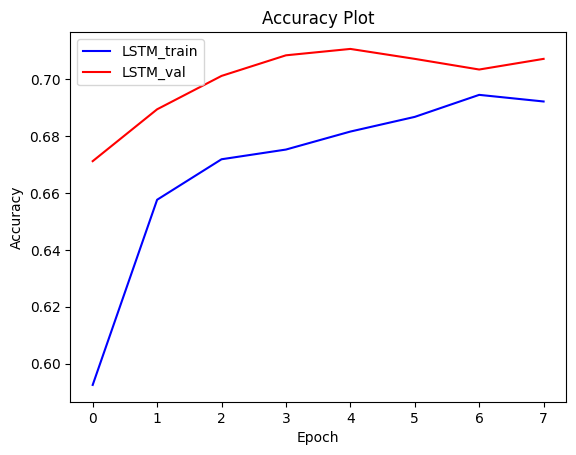

In [34]:
plt.plot(history.history['accuracy'], c= 'b')
plt.plot(history.history['val_accuracy'], c='r')
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['LSTM_train', 'LSTM_val'], loc='upper left')
plt.savefig('../imgs/accuracy_plot.png')
mlflow.log_artifact('../imgs/accuracy_plot.png')

plt.show()


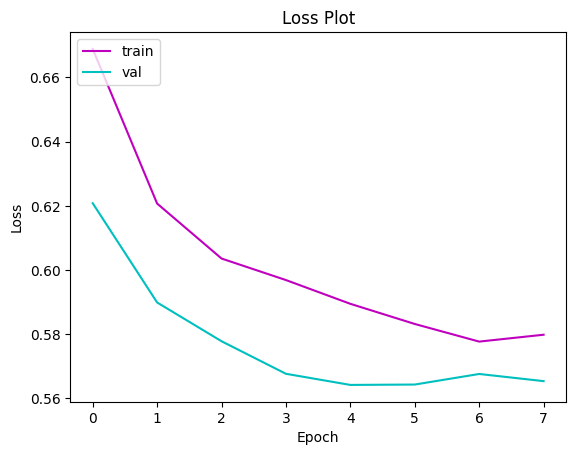

In [35]:

plt.plot(history.history['loss'], c='m')
plt.plot(history.history['val_loss'], c='c')
plt.title('Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.savefig('../imgs/loss_plot.png')
mlflow.log_artifact('../imgs/loss_plot.png')
plt.show()


In [36]:
# Track your experiment with MLflow
mlflow.log_metrics({'accuracy': accuracy})
mlflow.log_metrics({'loss': loss})

In [37]:
# Log hyperparameters
mlflow.log_params({'input_dim': len(word_index), 'output_dim': 300, 'input_length': max_len})
mlflow.log_params({'epochs': 8, 'batch_size': 1024})


In [38]:
# Save the model to a file
mlflow.log_artifact('../models/lstm_model_glove.pkl')

In [39]:
mlflow.end_run()

In [40]:
!mlflow ui

/Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/.venv2/lib/python3.10/site-packages/pydantic/_internal/_fields.py:128: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/drainasr-edine/github/ingenieur_ia/P7_drai_nasr-edine_app/.venv2/lib/python3.10/site-packages/pydantic/_internal/_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)
[2023-09-28 23:00:12 +0200] [43360] [INFO] Starting gunicorn 21.2.0
[2023-09-28 23:00:12 +0200] [43360] [INFO] Listening at: http://127.0.0.1:5000 (43360)
[2023-09-28 23:00:12 +0200] [43360] [INFO] Using worker: sync
[2023-09-28 23:00:12 +0200] [43361] [INFO] Booting worker with pid: 43361
[2023-09-28 23:00:12 +0200] [43362] [INFO] Booting worker with pid: 43362
[2023-09-28 23:00